In [2]:
#import the packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier
##%config InlineBackend.figure_format = 'svg'
%matplotlib inline

In [3]:
#read dataset
df = pd.read_csv("https://d17h27t6h515a5.cloudfront.net/topher/2017/October/59dd2e9a_noshowappointments-kagglev2-may-2016/noshowappointments-kagglev2-may-2016.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null float64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null object
AppointmentDay    110527 non-null object
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hipertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handcap           110527 non-null int64
SMS_received      110527 non-null int64
No-show           110527 non-null object
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


<i> As we can see, there isn't any missing data. So, we do not need to deal with it in our analysis.

In [7]:
df.describe()

,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026
std,2.560949e+14,7.129575e+04,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873
min,3.921784e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172614e+12,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173184e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.439172e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


<i> We can draw some simple conclusions looking at data in this general manner. 
1. The mean age of the sample is 37 years;
2. Scholarship is low, below 10%. This makes sense since the Bolsa Familia program is for low income families;
3. In general, SMS do not seens to be effective. We have a receive rate of only 32%.
4. There is some patient with more than 100 years on the max quartile. We will take a deeper look on it 

### Data Wrangling
To create more insights some transformations on the data are needed.
Below we will convert schedule and appointment dates to datetime.
It will help us with new columns such as simplified dates (`%d/%m/%Y`), the appointment and schedule hour and explore differences between these dates

In [4]:
#Lowercase the columns name, so we can type it better
df.columns = df.columns.str.lower()
#df.rename(columns=lambda x: x.lower(), inplace=True)

#Convert Schedule and Appointment date to datetime
df['new_scheduledday'] = pd.to_datetime(df['scheduledday']).dt.date
df['new_appointmentday'] = pd.to_datetime(df['appointmentday']).dt.date

#Convert PatientID to string, so we avoid the float datatype and cientific notation
df['patientid'] = df['patientid'].astype(str)

#Create new columns:
## Difference in days between schedule and appointment dates
df['diff_schedule_appointment'] = df['new_appointmentday'] - df['new_scheduledday']

##Create a period category with the difference in days between schedule and appointment. 
##This will help us to analyse different chunks of data
df['schedule_period'] = pd.cut(df.diff_schedule_appointment, bins=4, labels=['< 30 days','< 60 days', '< 90 days', '> 90 days'])

##Hour which the appointment was scheduled
df['appointment_hour'] = pd.to_datetime(df['appointmentday']).dt.hour

##Hour which the schedule was requested
df['schedule_hour'] = pd.to_datetime(df['scheduledday']).dt.hour

##Transform no-show data from categorical to numerical
df['no-show'].replace({'Yes':1, 'No':0}, inplace=True)

In [5]:
#Check if column age have negative values
df.query('age < 0')

,patientid,appointmentid,gender,scheduledday,appointmentday,age,neighbourhood,scholarship,hipertension,diabetes,alcoholism,handcap,sms_received,no-show,new_scheduledday,new_appointmentday,diff_schedule_appointment,schedule_period,appointment_hour,schedule_hour
99832,465943158731293.0,5775010,F,2016-06-06T08:58:13Z,2016-06-06T00:00:00Z,-1,ROMÃO,0,0,0,0,0,0,0,2016-06-06,2016-06-06,0 days,< 30 days,0,8


In [6]:
#Let's reassign df with a version without negative ages 
df = df.query('age >= 0')
#Check if there is any negative value in age
df.query('age < 0')

,patientid,appointmentid,gender,scheduledday,appointmentday,age,neighbourhood,scholarship,hipertension,diabetes,alcoholism,handcap,sms_received,no-show,new_scheduledday,new_appointmentday,diff_schedule_appointment,schedule_period,appointment_hour,schedule_hour


In [7]:
#Check if everything went fine
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110526 entries, 0 to 110526
Data columns (total 20 columns):
patientid                    110526 non-null object
appointmentid                110526 non-null int64
gender                       110526 non-null object
scheduledday                 110526 non-null object
appointmentday               110526 non-null object
age                          110526 non-null int64
neighbourhood                110526 non-null object
scholarship                  110526 non-null int64
hipertension                 110526 non-null int64
diabetes                     110526 non-null int64
alcoholism                   110526 non-null int64
handcap                      110526 non-null int64
sms_received                 110526 non-null int64
no-show                      110526 non-null int64
new_scheduledday             110526 non-null object
new_appointmentday           110526 non-null object
diff_schedule_appointment    110526 non-null timedelta64[ns]
sched

The new columns seems to be created correctly. Let's check out if the data make sense.
To verify it, we will create new dataframe instances with summarized data

In [8]:
print(df.duplicated().sum())

0


We also do not have duplicated rows, so we will start to create new variables to help in our analysis.

In [9]:
#Create the summarized datasets
df_diff = df.groupby('diff_schedule_appointment')['patientid'].count().to_frame().reset_index()
df_sch_period = df.groupby('schedule_period')['patientid'].count().to_frame().reset_index()
df_ahour = df.groupby('appointment_hour')['patientid'].count().to_frame().reset_index()
df_shour = df.groupby('schedule_hour')['patientid'].count().to_frame().reset_index()

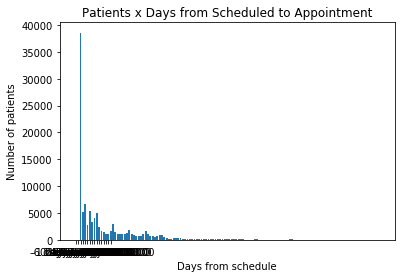

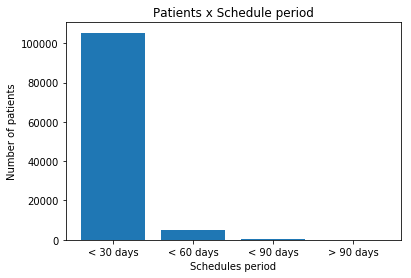

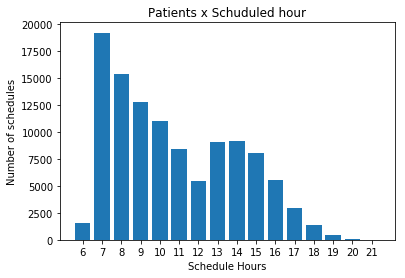

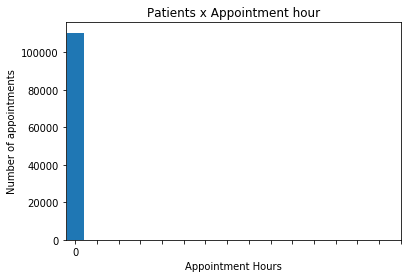

In [10]:
#Check if the new dataframes above will be useful on the analysis
df_index = np.arange(len(df_diff))
df_period_index = np.arange(len(df_sch_period))
shour_index = np.arange(len(df_shour))
ahour_index = np.arange(len(df_ahour))

#Defining df_diff plot
plt.bar(df_index, df_diff['patientid'])
plt.xlabel('Days from schedule')
plt.ylabel('Number of patients')
plt.xticks(shour_index, df_diff['diff_schedule_appointment'])
plt.title('Patients x Days from Scheduled to Appointment')
plt.show()

#Defininf df_sch_period
plt.bar(df_period_index, df_sch_period['patientid'])
plt.xlabel('Schedules period')
plt.ylabel('Number of patients')
plt.xticks(df_period_index, df_sch_period['schedule_period'])
plt.title('Patients x Schedule period')
plt.show()

#Defining the schedule hours plot
plt.bar(shour_index, df_shour['patientid'])
plt.xlabel('Schedule Hours')
plt.ylabel('Number of schedules')
plt.xticks(shour_index, df_shour['schedule_hour'])
plt.title('Patients x Schuduled hour')
plt.show()

#Defining the appointment hours plot
plt.bar(ahour_index, df_ahour['patientid'])
plt.xlabel('Appointment Hours')
plt.ylabel('Number of appointments')
plt.xticks(shour_index, df_ahour['appointment_hour'])
plt.title('Patients x Appointment hour')
plt.show()

Here we can see two important information:
1. The date diff column we created has value but due to many values, it's difficult to understand data efficiently. The period column created, that comes in the second plot shows a much more, pleasant view
2. There is a substantial number of rows where schedule data and appointment date are equal. This may be attributed to appointments performed without schedule in urgent cases. This is an assumption, we cannot affirm that based on the data we have.
3. The appointment hour seems to have bad data. There is any other data than "zero" hour, which doesn't makes sense.

## Data analysis

Here we will start to analyse our data. We will see some descriptive statistics and also some graphs.

### Patient demography

In [11]:
# What is the percentage of unique patientid's and total count?
print("Here, we see that unique patients id corresponds to {}% of the total count." 
      "That is, on average, a patient schedule an appoint twice.".
      format(round(df['patientid'].nunique() / df['patientid'].count() *100,2)))

Here, we see that unique patients id corresponds to 56.37% of the total count.That is, on average, a patient schedule an appoint twice.


In [12]:
unique_males_p = round(df[df['gender']== 'M']['patientid'].nunique() / df[df['gender']== 'M']['patientid'].count() *100, 2)  

In [13]:
unique_females_p = round(df[df['gender']== 'F']['patientid'].nunique() / df[df['gender']== 'F']['patientid'].count() * 100, 2)

In [14]:
print("Here we see that male and female patients do not varies too much.\n"
      "The first being with slightly higher number of unique patients.\n"
      "Males: {}%, Females: {}%".format(unique_males_p, unique_females_p))

Here we see that male and female patients do not varies too much.
The first being with slightly higher number of unique patients.
Males: 57.52%, Females: 55.74%


In [15]:
df[df['gender']=='M'].describe()

,appointmentid,age,scholarship,hipertension,diabetes,alcoholism,handcap,sms_received,no-show,diff_schedule_appointment,appointment_hour,schedule_hour
count,3.868700e+04,38687.000000,38687.000000,38687.000000,38687.000000,38687.000000,38687.000000,38687.000000,38687.000000,38687,38687.0,38687.000000
mean,5.677102e+06,33.736863,0.051904,0.167033,0.060408,0.055238,0.027270,0.291571,0.199679,9 days 14:14:12.193243,0.0,10.769096
std,6.990406e+04,24.435221,0.221836,0.373010,0.238244,0.228448,0.180917,0.454492,0.399765,14 days 19:33:18.889800,0.0,3.224494
min,5.122866e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1 days +00:00:00,0.0,6.000000
25%,5.642308e+06,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0 days 00:00:00,0.0,8.000000
50%,5.681916e+06,33.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3 days 00:00:00,0.0,10.000000
75%,5.726456e+06,54.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,14 days 00:00:00,0.0,13.000000
max,5.790466e+06,100.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000,1.000000,179 days 00:00:00,0.0,21.000000


In [16]:
df[df['gender']=='F'].describe()

,appointmentid,age,scholarship,hipertension,diabetes,alcoholism,handcap,sms_received,no-show,diff_schedule_appointment,appointment_hour,schedule_hour
count,7.183900e+04,71839.000000,71839.000000,71839.000000,71839.000000,71839.000000,71839.000000,71839.000000,71839.000000,71839,71839.0,71839.000000
mean,5.674336e+06,38.894542,0.123234,0.213519,0.078036,0.017024,0.019544,0.336892,0.203149,10 days 12:02:39.356338,0.0,10.777475
std,7.201549e+04,22.154889,0.328708,0.409794,0.268229,0.129362,0.150010,0.472651,0.402345,15 days 11:27:52.887224,0.0,3.211731
min,5.030230e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6 days +00:00:00,0.0,6.000000
25%,5.639222e+06,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0 days 00:00:00,0.0,8.000000
50%,5.679849e+06,39.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4 days 00:00:00,0.0,10.000000
75%,5.724902e+06,56.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,15 days 00:00:00,0.0,13.000000
max,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000,1.000000,179 days 00:00:00,0.0,21.000000


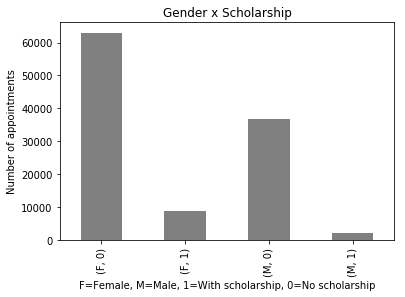

In [17]:
df.groupby(['gender','scholarship'])['appointmentid'].count().plot(kind='bar', 
                                                                   title='Gender x Scholarship',
                                                                   color='grey')
plt.ylabel('Number of appointments');
plt.xlabel('F=Female, M=Male, 1=With scholarship, 0=No scholarship');

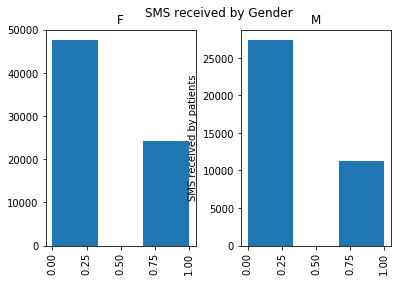

In [18]:
sms_plot = df['sms_received'].hist(grid=False, by=df['gender'], bins=3)
plt.suptitle('SMS received by Gender')
plt.ylabel('SMS received by patients');

In [23]:
#Getting the median of schedule to appointment, desconsidering difference equal zero days
df[df['diff_schedule_appointment'] != '0 days']['diff_schedule_appointment'].mean()

Timedelta('15 days 15:22:44.482241')

### Hospital neighbourhood information

Here we will check the top 10 hospital with more no-show

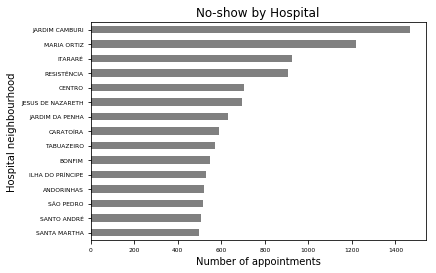

In [24]:
plt_ns_hosp = no_show_hosp = df[df['no-show'] == 1].groupby('neighbourhood')['appointmentid'].count()
plt_ns_hosp = no_show_hosp.nlargest(15)
plt_ns_hosp.sort_values(ascending=True).plot(kind='barh', fontsize=6, color='grey').set_title('No-show by Hospital')
plt.ylabel('Hospital neighbourhood')
plt.xlabel('Number of appointments');

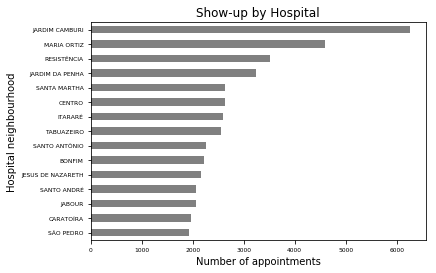

In [19]:
show_up_hosp = df[df['no-show']==0].groupby('neighbourhood')['appointmentid'].count()
show_up_hosp = show_up_hosp.nlargest(15)
show_up_hosp.sort_values(ascending=True).plot(kind='barh', fontsize=6, color='grey').set_title('Show-up by Hospital')
plt.ylabel('Hospital neighbourhood')
plt.xlabel('Number of appointments');

In [21]:
#Transform both hospital with no-show/show-up series to dataframe 
show_up_hosp = show_up_hosp.to_frame().reset_index()
no_show_hosp = no_show_hosp.to_frame().reset_index()

AttributeError: 'DataFrame' object has no attribute 'to_frame'

In [27]:
#Merge the datasets to understand no show rate
merged_hosp = pd.merge(show_up_hosp, no_show_hosp, how='inner', on='neighbourhood')
merged_hosp.rename(columns={'appointmentid_x':'show_up_qtd',
                           'appointmentid_y':'no_show_qtd'}, inplace=True)

#create total and % of no show for each hospital
merged_hosp['total'] = merged_hosp['show_up_qtd'] + merged_hosp['no_show_qtd']
merged_hosp['no_show_rate'] = round(merged_hosp['no_show_qtd'] / merged_hosp['total']*100, 2)

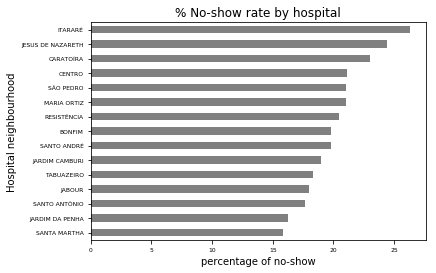

In [28]:
#Create a horizontal bar ordered by hospital with more no-show
m_hosp = merged_hosp.groupby('neighbourhood')['no_show_rate'].mean().sort_values(ascending=True)
m_hosp.plot(kind='barh',fontsize=6, color='grey').set_title('% No-show rate by hospital')
plt.ylabel('Hospital neighbourhood')
plt.xlabel('percentage of no-show');

In [29]:
print('The median of no-showsis: {}%'.format(merged_hosp['no_show_rate'].median()))

The median of no-showsis: 19.83%


In [30]:
#Create a dataset with schedules per hospital
hosp_cases = df[['neighbourhood','hipertension','diabetes', 'alcoholism', 'handcap', 'no-show']].groupby('neighbourhood').sum()
hosp_cases['total_occurences'] = hosp_cases['hipertension'] + hosp_cases['diabetes'] + hosp_cases['alcoholism'] + hosp_cases['handcap']

In [31]:
#Find the hospital with most occurences in general
hosp_cases[hosp_cases['total_occurences'] == hosp_cases['total_occurences'].max()]

,hipertension,diabetes,alcoholism,handcap,no-show,total_occurences
neighbourhood,,,,,,
SANTA MARTHA,720,278,344,121,496,1463


In [32]:
#Get the hospital with more hipertension patients
hosp_cases[hosp_cases['hipertension'] == hosp_cases['hipertension'].max()]

,hipertension,diabetes,alcoholism,handcap,no-show,total_occurences
neighbourhood,,,,,,
JARDIM DA PENHA,1002,327,25,83,631,1437


In [33]:
#Get the hospital with more diabetes patients
hosp_cases[hosp_cases['diabetes'] == hosp_cases['diabetes'].max()]

,hipertension,diabetes,alcoholism,handcap,no-show,total_occurences
neighbourhood,,,,,,
JARDIM DA PENHA,1002,327,25,83,631,1437


In [34]:
#Get the hospital with more alcoholism patients
hosp_cases[hosp_cases['alcoholism'] == hosp_cases['alcoholism'].max()]

,hipertension,diabetes,alcoholism,handcap,no-show,total_occurences
neighbourhood,,,,,,
SANTA MARTHA,720,278,344,121,496,1463


In [35]:
#Get the hospital with more handcap patients
hosp_cases[hosp_cases['handcap'] == hosp_cases['handcap'].max()]

,hipertension,diabetes,alcoholism,handcap,no-show,total_occurences
neighbourhood,,,,,,
SANTA MARTHA,720,278,344,121,496,1463


In [36]:
#Calculates the medical issues with more no-show occurences
df_no_show = df[df['no-show']==1]
df_no_show = df_no_show[['hipertension','diabetes', 'alcoholism', 'handcap', 'no-show']].sum().to_frame()
df_no_show.head()

,0
hipertension,3772
diabetes,1430
alcoholism,677
handcap,453
no-show,22319


## Creating a timeseries graph on schedule and appointment

Does the scheduling and appointment increase in specific periods of time? 

In [37]:
df_schedule = df.groupby('new_scheduledday')['appointmentid'].count()
df_appointment = df.groupby('new_appointmentday')['appointmentid'].count()

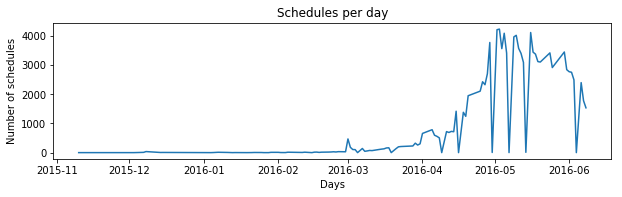

In [38]:
df_schedule.plot(figsize=(10,2.5)).set_title('Schedules per day')
plt.ylabel('Number of schedules')
plt.xlabel('Days');

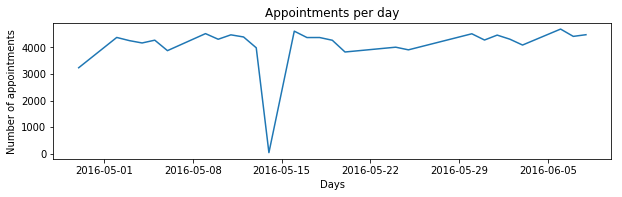

In [39]:
df_appointment.plot(figsize=(10,2.5)).set_title('Appointments per day')
plt.ylabel('Number of appointments')
plt.xlabel('Days');

As we can see, there was a really accelerated increase on scheduling from May-2016. However, we see a constant number of appointments, maybe due to a max capacity of the medical centers.

## Correlation analysis

Here we'try to figure out if there is any correlation between no-shows and other variables.
Below we run a correlation analysis to check it.

In [40]:
df.head()

,patientid,appointmentid,gender,scheduledday,appointmentday,age,neighbourhood,scholarship,hipertension,diabetes,alcoholism,handcap,sms_received,no-show,new_scheduledday,new_appointmentday,diff_schedule_appointment,schedule_period,appointment_hour,schedule_hour
0,29872499824296.0,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,0,2016-04-29,2016-04-29,0 days,< 30 days,0,18
1,558997776694438.0,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,0,2016-04-29,2016-04-29,0 days,< 30 days,0,16
2,4262962299951.0,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,0,2016-04-29,2016-04-29,0 days,< 30 days,0,16
3,867951213174.0,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,0,2016-04-29,2016-04-29,0 days,< 30 days,0,17
4,8841186448183.0,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,0,2016-04-29,2016-04-29,0 days,< 30 days,0,16


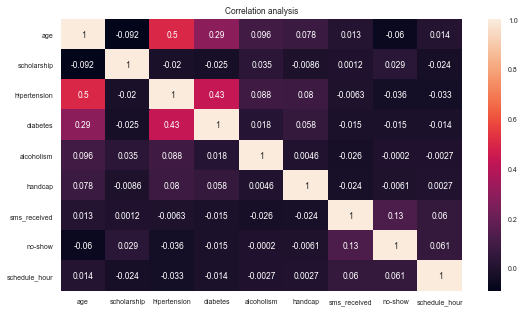

In [41]:
corr = df[['age',
           'scholarship',
           'hipertension',
           'diabetes',
           'alcoholism',
           'handcap',
           'sms_received',
           'no-show','schedule_hour']].corr()

plt.figure(figsize = (9,5))
sns.set(font_scale=0.7)
ax = sns.heatmap(corr, annot=True,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
ax.set_title('Correlation analysis');

As we can see, there is little correlation between variables including no-show.
The higher correlation coeficients are hipertension x age and hipertension x diabetes, which is moderated. A low correlation between diabetes and age can also be visualized.

## Conclusions

As we can see, this brief analsysis showed some interesting data although we cannot create any relevant insight. We also found some limitations on the data like:

### Limitations

1. Many records had the same scheduling and appointment date. Although we can't say that it is a problem, the dataset documentation don't explain it.
2. The appointment column did not data about the hour. We weren't able to explore which hours no-shows occurs the most.
3. Age column had some records with negative values. We droped it.

Thinking about how reality is reflected, this dataset lacks some important data such as the hospital name, state, scheduling type (telephone, website, in person) for example. A deeper analysis would benefit from it.

### Answers

To conclude, follow below the answers we collected:

1. Demography of the sample (age, sex, medical issue)
> The average age for male pacients is 33 years/old while for female patients it is 38 years. The scholarship for both groups (0.5 for male and 0.12 for female - representing more than the double than men patients).
> The median between scheduling and appointment date is 15 days, desconsidering rows where both columns have the same date.

2. Which hospital has more no-shows?
> The hospital that have more no-shows, in absolute numbers, is the hospital from Jardim Camburi. But comparing the percentages, we see that the medical center located in Itararé leads with 25% of no-shows (5% p.p from the median).

3. How many times a patient schedule an appointment
> Based on this data we see that, between Nov-2015 and May-2016, a 56% of the patients have scheduled an appoint at least 2 times. Men leads with 57.52% and Females 55.74%.

4. What medical issue drives more no-shows?
> The medical issue that leads more no-shows is hipertension (3772), followed by diabetes (1430), alcoholism (677) and handcap (453).
> The hospitals that has received more cases of hipertension and diabetes is the one located in Jardim da Penha while Santa Martha receives more patients from alcoholism and handcap.

5. There is a correlation between scholarship and no-show?
> Based on a simple correlation analysis, we didn't any strong relationship between theses variables and others too. Perhaps a machine learning model can tell us which feature has more impact on no-shows.

6. There is a correlation between received SMS and show-up?
> We also didn't see any correlation on this case. But on a the histogram on "Patient demography" we see that only one third of the patients received that SMS. This leads us to two questions that we cannot answer with this dataset: 1. How good is the patient database? 2. How eficient are those systems responsible for that?